In [1]:
from miipher.dataset.preprocess_for_infer import PreprocessForInfer
from miipher.lightning_module import MiipherLightningModule
from lightning_vocoders.models.hifigan.xvector_lightning_module import HiFiGANXvectorLightningModule
import torch
import transformers
import torchaudio
import hydra
import tempfile

miipher_path = "https://huggingface.co/spaces/Wataru/Miipher/resolve/main/miipher.ckpt"
miipher = MiipherLightningModule.load_from_checkpoint(miipher_path,map_location='cuda')
miipher.feature_extractor.to('cuda')
vocoder = HiFiGANXvectorLightningModule.load_from_checkpoint("https://huggingface.co/spaces/Wataru/Miipher/resolve/main/vocoder_finetuned.ckpt",map_location='cuda')
xvector_model = hydra.utils.instantiate(vocoder.cfg.data.xvector.model)
xvector_model = xvector_model.to('cpu')
preprocessor = PreprocessForInfer(miipher.cfg)

@torch.inference_mode()
def main(wav_path,transcript,lang_code,output_path_clean=None,output_path_resynth=None):
    global xvector_model, miipher, preprocessor, vocoder
    wav,sr =torchaudio.load(wav_path)
    wav = wav[0].unsqueeze(0)
    batch = preprocessor.process(
        'test',
        (torch.tensor(wav).to('cpu'),sr),
        word_segmented_text=transcript,
        lang_code=lang_code
    )
    print(batch.keys())
    for k,v in batch.items():
        if isinstance(v,torch.Tensor) or hasattr(v,'to'):
            batch[k] = v.to('cuda')
    miipher.feature_extractor(batch)
    (
        phone_feature,
        speaker_feature,
        degraded_ssl_feature,
        _,
    ) = miipher.feature_extractor(batch)
    cleaned_ssl_feature, _ = miipher(phone_feature.to('cuda'),speaker_feature.to('cuda'),degraded_ssl_feature.to('cuda'))
    vocoder_xvector = xvector_model.encode_batch(batch['degraded_wav_16k'].view(1,-1).to('cpu')).squeeze(1).to('cuda')
    if output_path_clean is not None:
        cleaned_wav = vocoder.generator_forward({"input_feature": cleaned_ssl_feature, "xvector": vocoder_xvector})[0].T
        torchaudio.save(output_path_clean,cleaned_wav.view(1,-1).cpu(), sample_rate=22050)
    if output_path_resynth is not None:
        resynth_wav = vocoder.generator_forward({"input_feature": degraded_ssl_feature, "xvector": vocoder_xvector})[0].T
        torchaudio.save(output_path_resynth,resynth_wav.view(1,-1).cpu(), sample_rate=22050)


Some weights of the model checkpoint at vinai/xphonebert-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/xphonebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
torchvision is

In [2]:
from pathlib import Path
jsut_wavs = [Path(f"/mnt/hdd/datasets/jsut_ver1.1/basic5000/wav/BASIC5000_{i:04d}.wav" ) for i in range(1,101)]
arctic_wavs = [list(Path("/mnt/hdd/datasets/cmu_arctic/cmu_us_bdl_arctic/").glob(f"**/arctic_a{i:04d}.wav")) for i in range(1,101)]
arctic_wavs.extend(list(Path("/mnt/hdd/datasets/cmu_arctic/cmu_us_slt_arctic/").glob(f"**/arctic_a{i:04d}.wav")) for i in range(1,101))
arctic_wavs.extend(list(Path("/mnt/hdd/datasets/cmu_arctic/cmu_us_clb_arctic/").glob(f"**/arctic_a{i:04d}.wav")) for i in range(1,101))
arctic_wavs.extend(list(Path("/mnt/hdd/datasets/cmu_arctic/cmu_us_rms_arctic/").glob(f"**/arctic_a{i:04d}.wav")) for i in range(1,101))
# arctic_wavs = [list(Path("/mnt/hdd/datasets/cmu_arctic/").glob("**/arctic_*{i:04d}.wav")) for i in range(1,101)]
#flatten arctic_wavs
arctic_wavs = [w for sublist in arctic_wavs for w in sublist]
assert all([w.exists() for w in arctic_wavs])
assert all([w.exists() for w in jsut_wavs])

In [3]:
import re
jsut_transcripts = {}
with (jsut_wavs[0].parent.parent / 'transcript_utf8.txt').open() as f:
    lines = f.readlines()
    jsut_transcripts = {line.split(':')[0].strip(): line.split(':')[1].strip() for line in lines} 
arctic_transcripts = {}
def arctic_path2_id(path):
    return path.parent.parent.name + "_" + path.stem

for arctic_wav in arctic_wavs:
    if arctic_path2_id(arctic_wav) in arctic_transcripts.keys():
        continue
    with (arctic_wav.parent.parent / "etc/txt.done.data").open() as f:
        lines =[l.strip() for l in f.readlines()]
        for line in lines:
            # ( wav_id "transcript")
            wav_id = re.sub(r"^\( (.+) \"(.+)\" \)$", r"\1", line)
            transcript = re.sub(r"^\( (.+) \"(.+)\" \)$", r"\2", line)
            arctic_transcripts[arctic_path2_id(arctic_wav)] = transcript
from miipher.preprocess.noiseAugmentation import DegrationApplier
# degrader = DegrationApplier(miipher.cfg.preprocess.degration)

In [10]:
vocoder = HiFiGANXvectorLightningModule.load_from_checkpoint("https://huggingface.co/spaces/Wataru/Miipher/resolve/main/vocoder_finetuned.ckpt",map_location='cuda')
#mkdirs
Path("arctic_resampled").mkdir(exist_ok=True)
Path("arctic_degraded_all").mkdir(exist_ok=True)
Path("arctic_degraded_backgroundNoise").mkdir(exist_ok=True)
Path("arctic_degraded_codec").mkdir(exist_ok=True)
Path("arctic_degraded_reverb").mkdir(exist_ok=True)
Path("arctic_miipher_resampled").mkdir(exist_ok=True)
Path("arctic_miipher_degraded_all").mkdir(exist_ok=True)
Path("arctic_miipher_degraded_backgroundNoise").mkdir(exist_ok=True)
Path("arctic_miipher_degraded_codec").mkdir(exist_ok=True)
Path("arctic_miipher_degraded_reverb").mkdir(exist_ok=True)
Path("arctic_resynth_resampled").mkdir(exist_ok=True)
Path("arctic_resynth_degraded_all").mkdir(exist_ok=True)
Path("arctic_resynth_degraded_backgroundNoise").mkdir(exist_ok=True)
Path("arctic_resynth_degraded_codec").mkdir(exist_ok=True)
Path("arctic_resynth_degraded_reverb").mkdir(exist_ok=True)
Path("jsut_resampled").mkdir(exist_ok=True)
Path("jsut_degraded_all").mkdir(exist_ok=True)
Path("jsut_degraded_backgroundNoise").mkdir(exist_ok=True)
Path("jsut_degraded_codec").mkdir(exist_ok=True)
Path("jsut_degraded_reverb").mkdir(exist_ok=True)
Path("jsut_miipher_resampled").mkdir(exist_ok=True)
Path("jsut_miipher_degraded_all").mkdir(exist_ok=True)
Path("jsut_miipher_degraded_backgroundNoise").mkdir(exist_ok=True)
Path("jsut_miipher_degraded_codec").mkdir(exist_ok=True)
Path("jsut_miipher_degraded_reverb").mkdir(exist_ok=True)
Path("jsut_resynth_resampled").mkdir(exist_ok=True)
Path("jsut_resynth_degraded_all").mkdir(exist_ok=True)
Path("jsut_resynth_degraded_backgroundNoise").mkdir(exist_ok=True)
Path("jsut_resynth_degraded_codec").mkdir(exist_ok=True)
Path("jsut_resynth_degraded_reverb").mkdir(exist_ok=True)
Path("aru_resampled").mkdir(exist_ok=True)
Path("aru_degraded_all").mkdir(exist_ok=True)
Path("aru_degraded_backgroundNoise").mkdir(exist_ok=True)
Path("aru_degraded_codec").mkdir(exist_ok=True)
Path("aru_degraded_reverb").mkdir(exist_ok=True)
Path("aru_miipher_resampled").mkdir(exist_ok=True)
Path("aru_miipher_degraded_all").mkdir(exist_ok=True)
Path("aru_miipher_degraded_backgroundNoise").mkdir(exist_ok=True)
Path("aru_miipher_degraded_codec").mkdir(exist_ok=True)
Path("aru_miipher_degraded_reverb").mkdir(exist_ok=True)
Path("aru_resynth_resampled").mkdir(exist_ok=True)
Path("aru_resynth_degraded_all").mkdir(exist_ok=True)
Path("aru_resynth_degraded_backgroundNoise").mkdir(exist_ok=True)
Path("aru_resynth_degraded_codec").mkdir(exist_ok=True)
Path("aru_resynth_degraded_reverb").mkdir(exist_ok=True)


for corpus in ['arctic']:
    if corpus == 'jsut':
        wavs = jsut_wavs
        transcripts = jsut_transcripts
    elif corpus == 'arctic':
        wavs = arctic_wavs
        transcripts = arctic_transcripts
    else:
        raise ValueError
    # prepare degraded wav
    for wav in wavs:
        break
        if corpus == 'jsut':
            input_wav,sr = torchaudio.load(wav)
            input_wav = torchaudio.functional.resample(input_wav,sr,22050)
            torchaudio.save(f"jsut_resampled/{wav.name}",input_wav.view(1,-1),sample_rate=22050)
            transcript = transcripts[wav.stem]
            degraded_wav = degrader(input_wav,22050)
            torchaudio.save(f"jsut_degraded_all/{wav.name}",degraded_wav.view(1,-1),sample_rate=22050)
            degraded_wav = degrader.applyBackgroundNoise(input_wav,22050)
            torchaudio.save(f"jsut_degraded_backgroundNoise/{wav.name}",degraded_wav.view(1,-1),sample_rate=22050)
            degraded_wav = degrader.applyCodec(input_wav,22050)
            torchaudio.save(f"jsut_degraded_codec/{wav.name}",degraded_wav.view(1,-1),sample_rate=22050)
            degraded_wav = degrader.applyReverb(input_wav)
            torchaudio.save(f"jsut_degraded_reverb/{wav.name}",degraded_wav.view(1,-1),sample_rate=22050)
        elif corpus == 'arctic':
            input_wav,sr = torchaudio.load(wav)
            input_wav = torchaudio.functional.resample(input_wav,sr,22050)
            torchaudio.save(f"arctic_resampled/{arctic_path2_id(wav)}.wav",input_wav.view(1,-1),sample_rate=22050)
            transcript = transcripts[arctic_path2_id(wav)]
            degraded_wav = degrader(input_wav,22050)
            torchaudio.save(f"arctic_degraded_all/{arctic_path2_id(wav)}.wav",degraded_wav.view(1,-1),sample_rate=22050)
            degraded_wav = degrader.applyBackgroundNoise(input_wav,22050)
            torchaudio.save(f"arctic_degraded_backgroundNoise/{arctic_path2_id(wav)}.wav",degraded_wav.view(1,-1),sample_rate=22050)
            degraded_wav = degrader.applyCodec(input_wav,22050)
            torchaudio.save(f"arctic_degraded_codec/{arctic_path2_id(wav)}.wav",degraded_wav.view(1,-1),sample_rate=22050)
            degraded_wav = degrader.applyReverb(input_wav)
            torchaudio.save(f"arctic_degraded_reverb/{arctic_path2_id(wav)}.wav",degraded_wav.view(1,-1),sample_rate=22050)
    for mode in ['resynth']:
    # for mode in ['miipher','resynth']:
        if mode == 'miipher':
            vocoder = HiFiGANXvectorLightningModule.load_from_checkpoint("https://huggingface.co/spaces/Wataru/Miipher/resolve/main/vocoder_finetuned.ckpt",map_location='cuda')
        else:
            vocoder = HiFiGANXvectorLightningModule.load_from_checkpoint("https://huggingface.co/Wataru/ssl-vocoder/resolve/main/wavlm-large-l8-xvector/wavlm-large-l8-xvector.ckpt",map_location='cuda')
        for condition in ['resampled', 'degraded_all', 'degraded_backgroundNoise', 'degraded_codec', 'degraded_reverb']:
            for wav in wavs:
                if corpus == 'jsut':
                    transcript = transcripts[wav.stem]
                    input_wav = Path(f"jsut_{condition}") / wav.name
                    if mode == 'miipher':
                        main(input_wav,transcript,'jpn', f"jsut_miipher_{condition}/{wav.name}")
                    else:
                        #resynth
                        main(input_wav,transcript,'jpn', output_path_resynth=f"jsut_resynth_{condition}/{wav.name}")
                elif corpus == 'arctic':
                    transcript = transcripts[arctic_path2_id(wav)]
                    input_wav = Path(f"arctic_{condition}") / (arctic_path2_id(wav) +".wav")
                    if mode == 'miipher':
                        main(input_wav,transcript,'eng-us', f"arctic_miipher_{condition}/{arctic_path2_id(wav)}.wav")
                    else:
                        #resynth
                        main(input_wav,transcript,'eng-us', output_path_resynth=f"arctic_resynth_{condition}/{arctic_path2_id(wav)}.wav")

/tmp/ipykernel_3279107/2834249727.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (torch.tensor(wav).to('cpu'),sr),


dict_keys(['phoneme_input_ids', 'degraded_ssl_input', 'degraded_wav_16k', 'degraded_wav_16k_lengths'])
torch.Size([1, 512])


/home/wnakata/miipher-evaluation/venv/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


dict_keys(['phoneme_input_ids', 'degraded_ssl_input', 'degraded_wav_16k', 'degraded_wav_16k_lengths'])
torch.Size([1, 512])
dict_keys(['phoneme_input_ids', 'degraded_ssl_input', 'degraded_wav_16k', 'degraded_wav_16k_lengths'])
torch.Size([1, 512])
dict_keys(['phoneme_input_ids', 'degraded_ssl_input', 'degraded_wav_16k', 'degraded_wav_16k_lengths'])
torch.Size([1, 512])
dict_keys(['phoneme_input_ids', 'degraded_ssl_input', 'degraded_wav_16k', 'degraded_wav_16k_lengths'])
torch.Size([1, 512])
dict_keys(['phoneme_input_ids', 'degraded_ssl_input', 'degraded_wav_16k', 'degraded_wav_16k_lengths'])
torch.Size([1, 512])
dict_keys(['phoneme_input_ids', 'degraded_ssl_input', 'degraded_wav_16k', 'degraded_wav_16k_lengths'])
torch.Size([1, 512])
dict_keys(['phoneme_input_ids', 'degraded_ssl_input', 'degraded_wav_16k', 'degraded_wav_16k_lengths'])
torch.Size([1, 512])
dict_keys(['phoneme_input_ids', 'degraded_ssl_input', 'degraded_wav_16k', 'degraded_wav_16k_lengths'])
torch.Size([1, 512])
dict_key

In [71]:
import pyworld
import os
import sys
import librosa
import numpy as np
import pyworld
import torch
import pysptk
from nnmnkwii.metrics import melcd,lf0_mean_squared_error
from .xvector_jtubespeech import XVector
from scipy.io import wavfile
import torchaudio
from torchaudio.compliance import kaldi
from sklearn.metrics.pairwise import cosine_similarity
def get_mcd(row):
    sr = 16_000
    FRAME_PERIOD = 5.0 #default 5.0
    alpha = 0.65  # commonly used at 22050 Hz
    fft_size = 512 #default 512
    mcep_size = 34 #default 34
    wav1 = row['wav_paths']
    if "jsut" in str(wav1):
        wav2 = Path("./jsut_resampled") /Path(row['wav_paths']).name
    else:
        wav2 = Path("./arctic_resampled") /Path(row['wav_paths']).name
    if wav1 == wav2:
        return 0
    wav1,_ = librosa.load(wav1,sr=sr,mono=True)
    wav2,_= librosa.load(wav2,sr=sr,mono=True)
    _, sp1, _ = pyworld.wav2world(wav1.astype(np.double), fs=sr, frame_period=FRAME_PERIOD, fft_size=fft_size)
    # Extract MCEP features
    mgc1 = pysptk.sptk.mcep(sp1, order=mcep_size, alpha=alpha, maxiter=0, etype=1, eps=1.0E-8, min_det=0.0, itype=3)
    # Use WORLD vocoder to spectral envelope
    _, sp2, _ = pyworld.wav2world(wav2.astype(np.double), fs=sr,frame_period=FRAME_PERIOD, fft_size=fft_size)
    # Extract MCEP features
    mgc2 = pysptk.sptk.mcep(sp2, order=mcep_size, alpha=alpha, maxiter=0, etype=1, eps=1.0E-8, min_det=0.0, itype=3)

    ref_frame_no = len(mgc1)

    min_cost, wp = librosa.sequence.dtw(mgc1[:, 1:].T, mgc2[:, 1:].T)
   
    result = melcd(mgc1[wp[:,0]], mgc2[wp[:,1]] , lengths=None)
    return result
def get_logf0mse(row):
    sr=22050
    FRAME_PERIOD = 5.0 #default 5.0
    fft_size = 512 #default 512
    wav1 = row['wav_paths']
    if "jsut" in str(wav1):
        wav2 = Path("./jsut_resampled") /Path(row['wav_paths']).name
    else:
        wav2 = Path("./arctic_resampled") /Path(row['wav_paths']).name
    if wav1 == wav2:
        return 0
    wav1,_ = librosa.load(wav1,sr=sr,mono=True)
    wav2,_ = librosa.load(wav2,sr=sr,mono=True)
    f0_1, sp_1, ap_1 = pyworld.wav2world(wav1.astype(np.double), fs=sr, frame_period=FRAME_PERIOD, fft_size=fft_size)
    f0_2, sp_2, ap_2 = pyworld.wav2world(wav2.astype(np.double), fs=sr,frame_period=FRAME_PERIOD, fft_size=fft_size)
    length = min(f0_1.shape[0],f0_2.shape[0])
    f0_1 = f0_1[:length]
    f0_2 = f0_2[:length]
    assert length != 0
    vuv_1 = (f0_1>0).astype(np.float32)
    vuv_2 = (f0_2>0).astype(np.float32)
    value =np.sqrt(lf0_mean_squared_error(f0_1,vuv_1,f0_2,vuv_2))
    return value

xvector_model = XVector("/home/wnakata/.cache/torch/hub/checkpoints/xvector.pth")
def extract_xvector(
  model, # xvector model
  wav   # 16kHz mono
):
  # extract mfcc
  wav = torch.from_numpy(wav.astype(np.float32)).unsqueeze(0)
  mfcc = kaldi.mfcc(wav, num_ceps=24, num_mel_bins=24) # [1, T, 24]
  mfcc = mfcc.unsqueeze(0)

  # extract xvector
  xvector = model.vectorize(mfcc) # (1, 512)
  xvector = xvector.to("cpu").detach().numpy().copy()[0]  

  return xvector
def get_xvector_similarity(row):
    wav1 = row['wav_paths']
    if "jsut" in str(wav1):
        wav2 = Path("./jsut_resampled") /Path(row['wav_paths']).name
    else:
        wav2 = Path("./arctic_resampled") /Path(row['wav_paths']).name
    if wav1 == wav2:
        return 0
    wav1,sr1 = torchaudio.load(wav1)
    wav2,sr2 = torchaudio.load(wav2)
    wav1 = wav1.view(1,-1)
    wav2 = wav2.view(1,-1)
    wav_resampled1 = torchaudio.functional.resample(torch.tensor(wav1),sr1,16_000)
    wav_resampled2 = torchaudio.functional.resample(torch.tensor(wav2),sr2,16_000)
    xvector1 = extract_xvector(xvector_model,wav_resampled1.view(-1).numpy())
    xvector2 = extract_xvector(xvector_model,wav_resampled2.view(-1).numpy())
    return cosine_similarity(xvector1.reshape(1,-1),xvector2.reshape(1,-1))[0][0]
from torchmetrics.audio import SignalNoiseRatio
def get_snr(row):
    wav1 = row['wav_paths']
    if "jsut" in str(wav1):
        wav2 = Path("./jsut_resampled") /Path(row['wav_paths']).name
    else:
        wav2 = Path("./arctic_resampled") /Path(row['wav_paths']).name
    if wav1 == wav2:
        return 0
    wav1,sr1 = torchaudio.load(wav1)
    wav2,sr2 = torchaudio.load(wav2)
    wav1 = wav1.view(1,-1)
    wav2 = wav2.view(1,-1)
    wav_resampled2 = torchaudio.functional.resample(wav2,sr2,sr1)
    min_size = min(wav1.shape[1],wav_resampled2.shape[1])
    wav1 = wav1[:,:min_size]
    wav_resampled2 = wav_resampled2[:,:min_size]
    return SignalNoiseRatio()(wav1,wav_resampled2).view(-1).item()
import whisper
whisper_model = whisper.load_model("base").to('cuda')
def get_asr(row):
    if "jsut" in str(row['wav_paths']):
        segments = whisper_model.transcribe(str(row['wav_paths']),language='ja')
    else:
        segments = whisper_model.transcribe(str(row['wav_paths']),language='en')
    return segments['text']
def get_transcript(row):
    if "jsut" in str(row['wav_paths']):
        return jsut_transcripts[row['wav_paths'].stem]
    else:
        return arctic_transcripts[row['wav_paths'].stem]


In [72]:
import pandas as pd

wavs, model,langs,speaker,degration,labels = [], [],[],[],[],[]
output_dirs = [
"jsut_resampled",
"jsut_degraded_all",
"jsut_degraded_backgroundNoise",
"jsut_degraded_codec",
"jsut_degraded_reverb",
"arctic_resampled",
"arctic_degraded_all",
"arctic_degraded_backgroundNoise",
"arctic_degraded_codec",
"arctic_degraded_reverb",
"jsut_miipher_resampled",
"jsut_miipher_degraded_all",
"jsut_miipher_degraded_backgroundNoise",
"jsut_miipher_degraded_codec",
"jsut_miipher_degraded_reverb",
"arctic_miipher_resampled",
"arctic_miipher_degraded_all",
"arctic_miipher_degraded_backgroundNoise",
"arctic_miipher_degraded_codec",
"arctic_miipher_degraded_reverb",
"jsut_resynth_resampled",
"jsut_resynth_degraded_all",
"jsut_resynth_degraded_backgroundNoise",
"jsut_resynth_degraded_codec",
"jsut_resynth_degraded_reverb",
"arctic_resynth_resampled",
"arctic_resynth_degraded_all",
"arctic_resynth_degraded_backgroundNoise",
"arctic_resynth_degraded_codec",
"arctic_resynth_degraded_reverb",
]
for output_dir in output_dirs:
    wav_subdirs = Path(output_dir).glob("*.wav")
    for wav in wav_subdirs:
        wavs.append(wav)
        if output_dir.startswith("jsut"):
            langs.append("jp")
        else:
            langs.append("en")
        if "miipher" in output_dir:
            model.append("miipher")
        elif 'resynth' in output_dir:
            model.append("resynth")
        else:
            model.append("wav")
        if "degraded_all" in output_dir:
            degration.append("all")
        elif "degraded_backgroundNoise" in output_dir:
            degration.append("backgroundNoise")
        elif "degraded_codec" in output_dir:
            degration.append("codec")
        elif "degraded_reverb" in output_dir:
            degration.append("reverb")
        else:
            degration.append("none")
        if "jsut" in output_dir:
            speaker.append("jsut")
        elif "arctic" in output_dir:
            if "slt" in str(wav):
                speaker.append("slt_F")
            elif 'bdl' in str(wav):
                speaker.append("bdl_M")
            elif 'rms' in str(wav):
                speaker.append("rms_M")
            elif 'clb' in str(wav):
                speaker.append("clb_F")
        assert len(wavs) == len(model) == len(langs) == len(speaker) == len(degration)
df = pd.DataFrame()
df['wav_paths'] = wavs
df['model'] = model
df['lang'] = langs
df['speaker'] = speaker
df['degration'] = degration

In [73]:
df

wav_paths    model lang speaker  \
0                     jsut_resampled/BASIC5000_0028.wav      wav   jp    jsut   
1                     jsut_resampled/BASIC5000_0098.wav      wav   jp    jsut   
2                     jsut_resampled/BASIC5000_0050.wav      wav   jp    jsut   
3                     jsut_resampled/BASIC5000_0001.wav      wav   jp    jsut   
4                     jsut_resampled/BASIC5000_0062.wav      wav   jp    jsut   
...                                                 ...      ...  ...     ...   
7495  arctic_resynth_degraded_reverb/cmu_us_rms_arct...  resynth   en   rms_M   
7496  arctic_resynth_degraded_reverb/cmu_us_bdl_arct...  resynth   en   bdl_M   
7497  arctic_resynth_degraded_reverb/cmu_us_rms_arct...  resynth   en   rms_M   
7498  arctic_resynth_degraded_reverb/cmu_us_slt_arct...  resynth   en   slt_F   
7499  arctic_resynth_degraded_reverb/cmu_us_clb_arct...  resynth   en   clb_F   

     degration  
0         none  
1         none  
2         none  
3         none  
4         none  
...        ...  
7495    reverb  
7496    reverb  
7497    reverb  
7498    reverb  
7499    reverb  

[7500 rows x 5 columns]

In [74]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
df['lf0_mse'] = df.parallel_apply(get_logf0mse,axis=1)
df['xvector_similarity'] = df.apply(get_xvector_similarity,axis=1)
df['mcd'] = df.parallel_apply(get_mcd,axis=1)
df['transcript'] = df.parallel_apply(get_transcript,axis=1)
df['asr'] = df.apply(get_asr,axis=1)
# df['snr'] = df.apply(get_snr,axis=1)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/wnakata/miipher-evaluation/venv/lib/python3.10/site-packages/nnmnkwii/metrics/__init__.py:99: RuntimeWarning: Mean of empty slice.
  return math.sqrt(float((z * z).mean()))
/home/wnakata/miipher-evaluation/venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/wnakata/miipher-evaluation/venv/lib/python3.10/site-packages/nnmnkwii/metrics/__init__.py:99: RuntimeWarning: Mean of empty slice.
  return math.sqrt(float((z * z).mean()))
/home/wnakata/miipher-evaluation/venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/wnakata/miipher-evaluation/venv/lib/python3.10/site-packages/nnmnkwii/metrics/__init__.py:99: RuntimeWarning: Mean of empty slice.
  return math.sqrt(float((z * z).mean()))
/home/wnakata/miipher-evaluation/venv/lib/python3.10/site-packages/numpy/core/_me

In [13]:
from jiwer import cer
def get_cer(row):
    return cer(row['transcript'],row['asr'])
df['cer'] = df.apply(get_cer,axis=1)

In [14]:
df.to_pickle("evaluation.pkl")

In [1]:
import pandas as pd
df = pd.read_pickle("evaluation.pkl")

In [2]:
def get_label(row):
    degration = row['degration']
    if row['model'] == 'miipher' and degration == 'none':
        return 'wav -> SSL -> FC -> wav'
    if row['model'] == 'resynth' and degration == 'none':
        return 'wav -> SSL -> wav'
    if row['model'] == 'resynth' and degration != 'none':
        return 'degraded -> SSL -> wav'
    if row['model'] == 'miipher' and degration != 'none':
        return 'degraded -> SSL -> FC -> wav'
    if row['model'] == 'wav' and degration == 'none':
        return 'wav'
    if row['model'] == 'wav' and degration != 'none':
        return 'degraded'

In [3]:
df['degration'].value_counts()

degration
none               1500
all                1500
backgroundNoise    1500
codec              1500
reverb             1500
Name: count, dtype: int64

In [4]:
df['label'].value_counts()

KeyError: 'label'

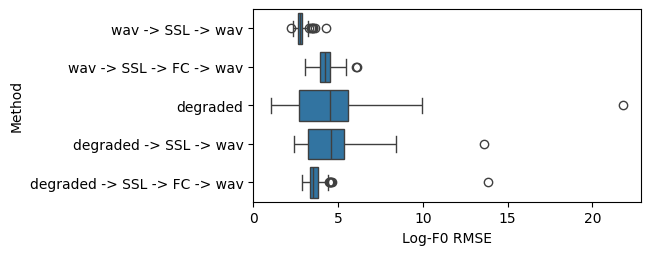

Text(0.5, 0, 'Log-F0 RMSE')

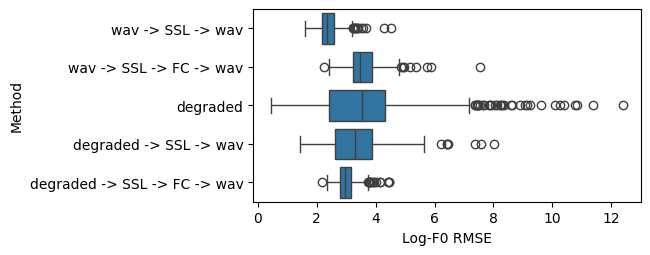

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt
df['label'] = df.apply(get_label,axis=1)
df['sort_index'] = df['label'].map({'wav':0,'degraded':3,'wav -> SSL -> wav':1,'wav -> SSL -> FC -> wav':2,'degraded -> SSL -> wav':4,'degraded -> SSL -> FC -> wav':5})
plot_df =df[df['degration'].str.contains('all|none',regex=True)].sort_values('sort_index')
jp_df = plot_df[plot_df['lang']=='jp' ]
en_df = plot_df[plot_df['lang']=='en' ]
plt.figure(figsize=(5,2.5))
sns.boxplot(jp_df[jp_df['label'] !='wav'],y='label', x='lf0_mse',orient='h')
plt.ylabel("Method")
plt.xlabel("Log-F0 RMSE")
plt.show()
plt.figure(figsize=(5,2.5))
sns.boxplot(en_df[en_df['label'] !='wav'],y='label', x='lf0_mse',orient='h')
plt.ylabel("Method")
plt.xlabel("Log-F0 RMSE")

Text(0, 0.5, 'Method')

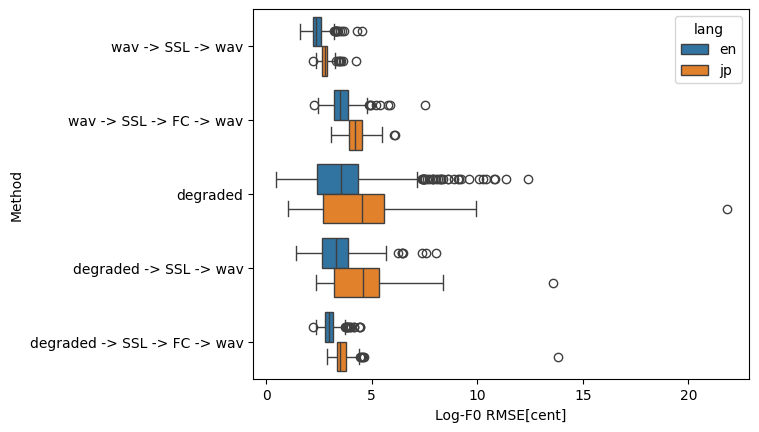

In [6]:
sns.boxplot(plot_df[plot_df.label!='wav'],y='label', x='lf0_mse',orient='h',hue='lang')
plt.xlabel("Log-F0 RMSE[cent]")
plt.ylabel("Method")

Text(0.5, 0, 'Xvector cosine similarity')

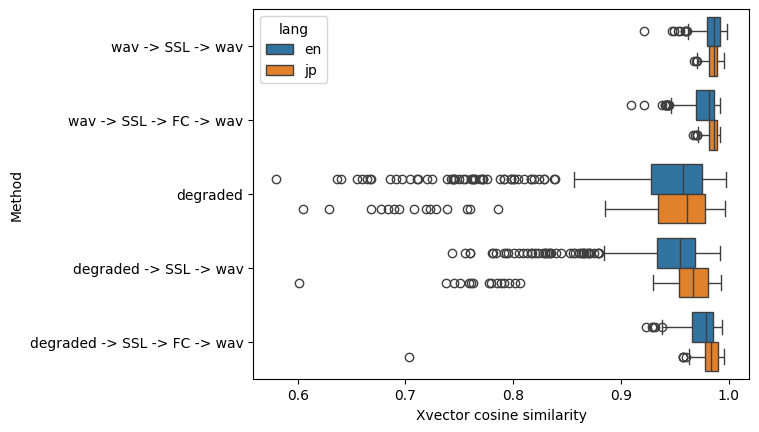

In [7]:
import seaborn as sns
# plt.figure(figsize=(5,2.5))
sns.boxplot(plot_df[plot_df['label']!='wav'],y='label', x='xvector_similarity',orient='h',hue='lang')
plt.ylabel("Method")
plt.xlabel("Xvector cosine similarity")

Text(0.5, 0, 'MCD[dB]')

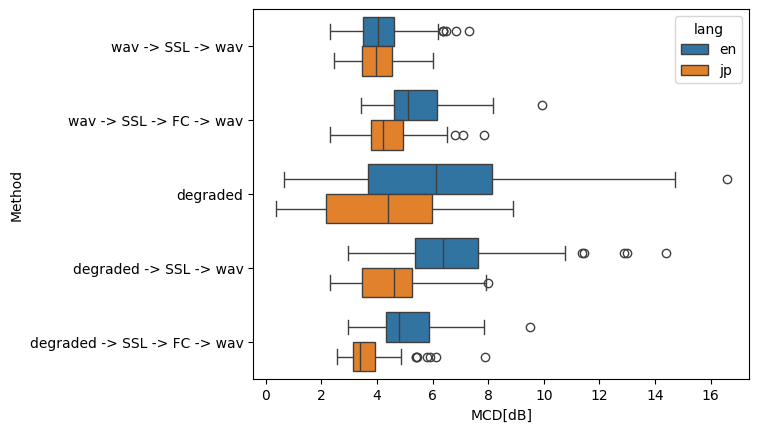

In [8]:
import seaborn as sns
sns.boxplot(plot_df[plot_df.label!='wav'],y='label', x='mcd',orient='h',hue='lang')
plt.ylabel("Method")
plt.xlabel("MCD[dB]")

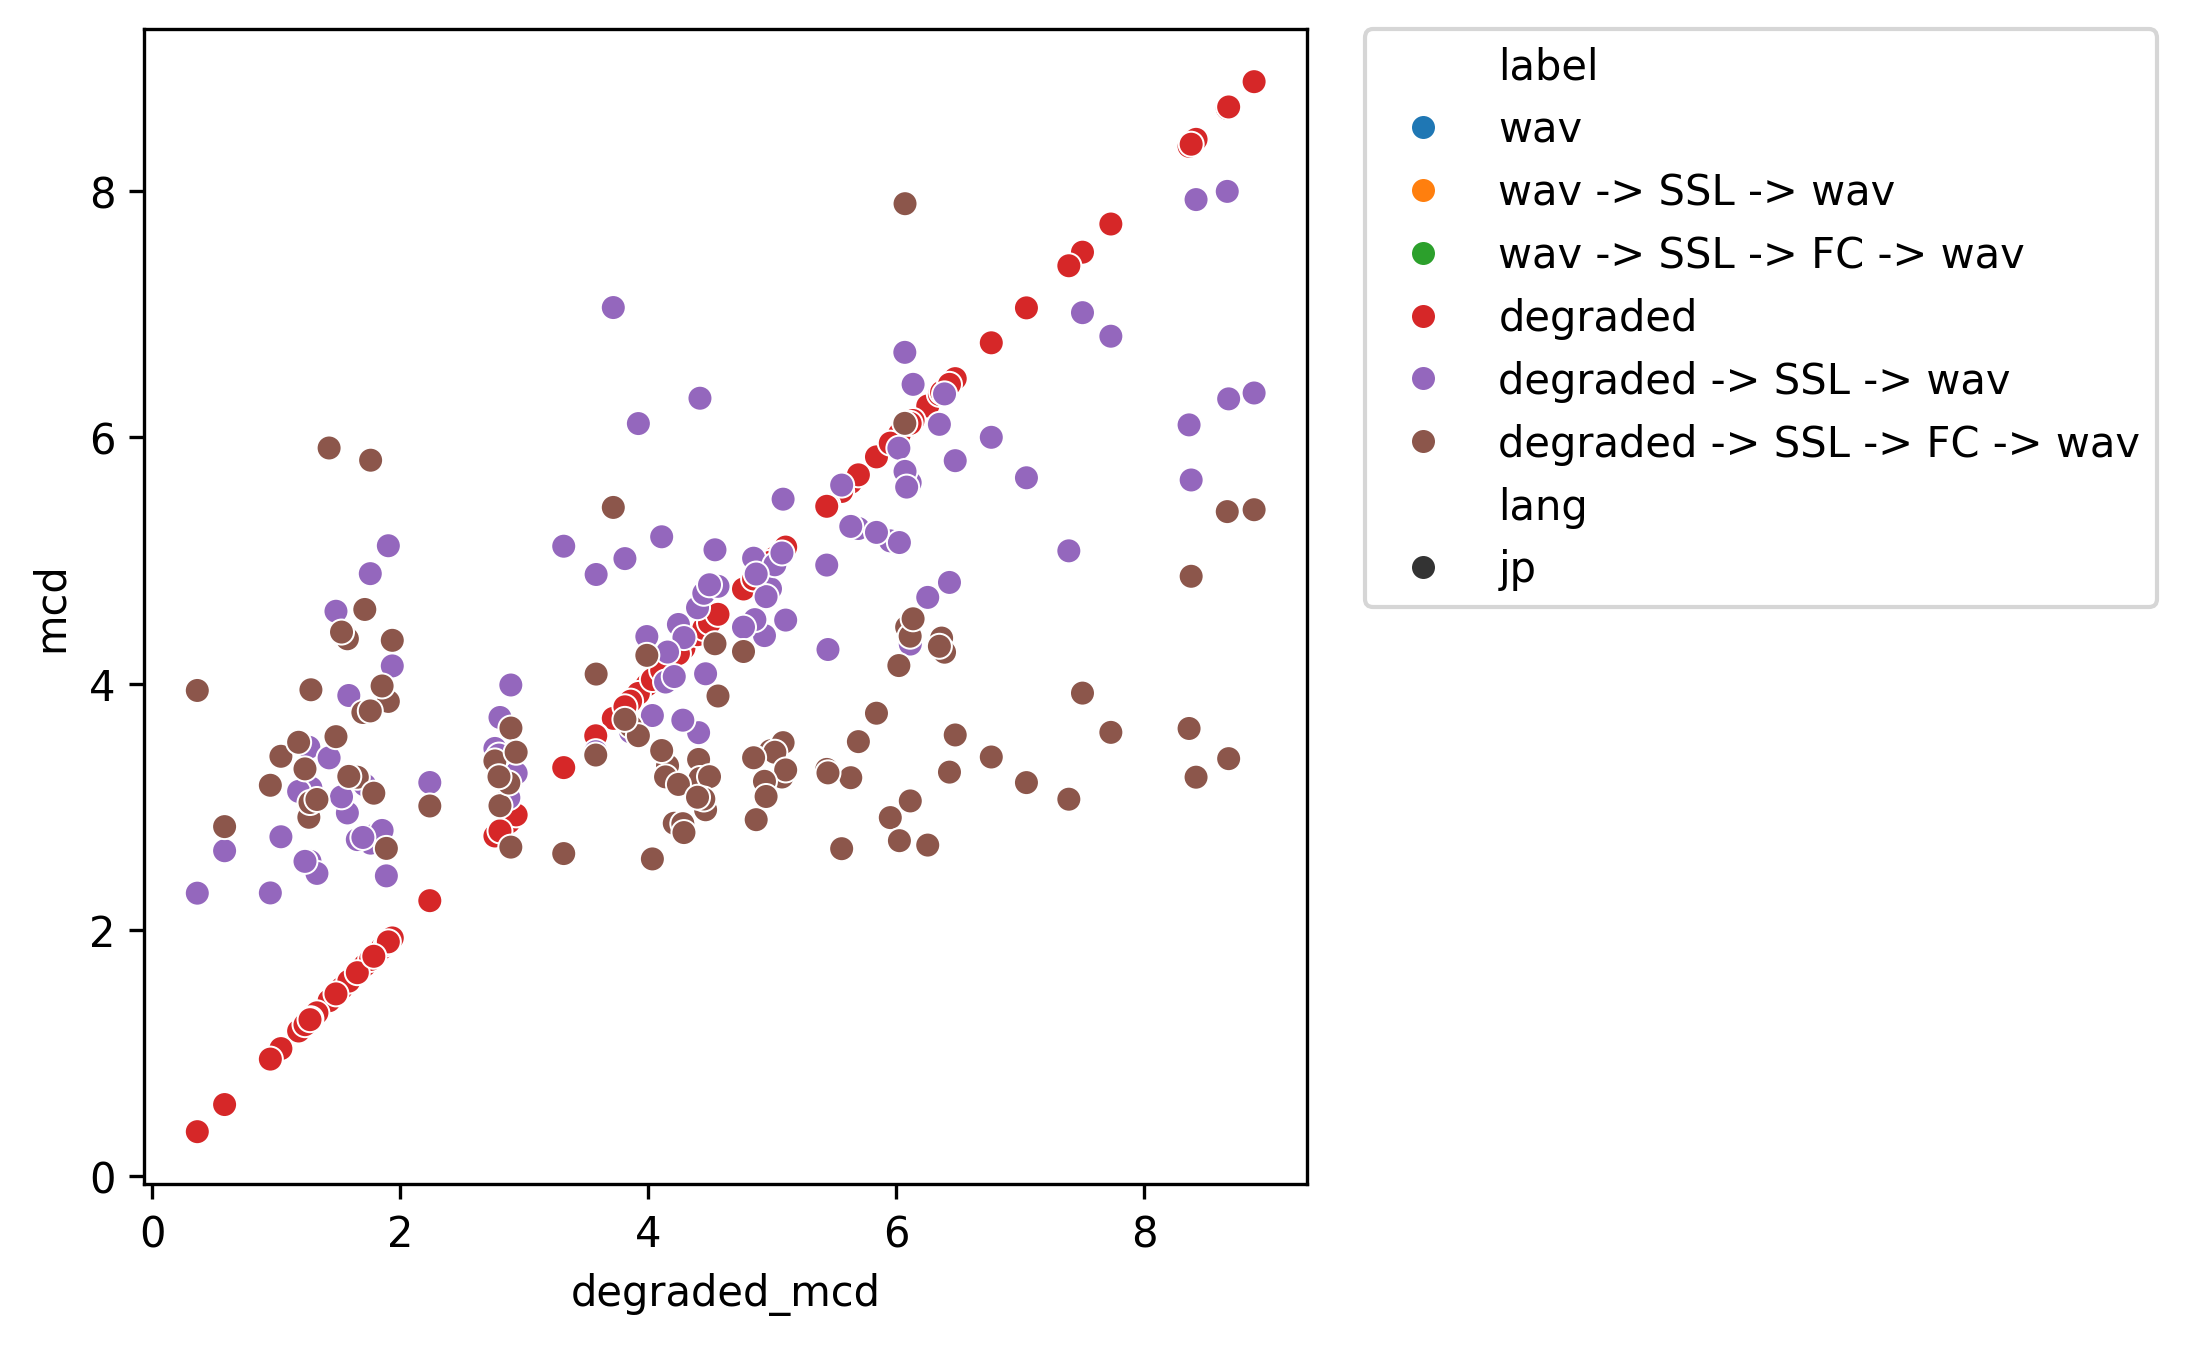

In [13]:
def get_degraded_mcd(row):
    if 'degraded' not in str(row['label']):
        return None
    return plot_df[(plot_df['label'] == 'degraded') & plot_df['wav_paths'].map(str).str.contains(row['wav_paths'].stem)]['mcd'].values[0]
plot_df['degraded_mcd'] = plot_df.apply(get_degraded_mcd,axis=1)
jp_df = plot_df[plot_df.lang == 'jp']
en_df = plot_df[plot_df.lang == 'en']
plt.figure(figsize=(5,5),dpi=300)
sns.scatterplot(jp_df[(jp_df['degraded_mcd'] !=None)].drop(),x='degraded_mcd', y='mcd',hue='label',style='lang')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

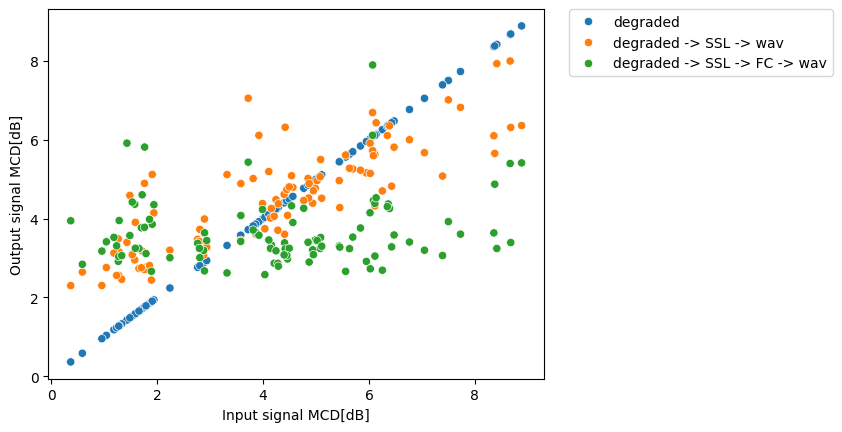

Text(0, 0.5, 'Output signal MCD[dB]')

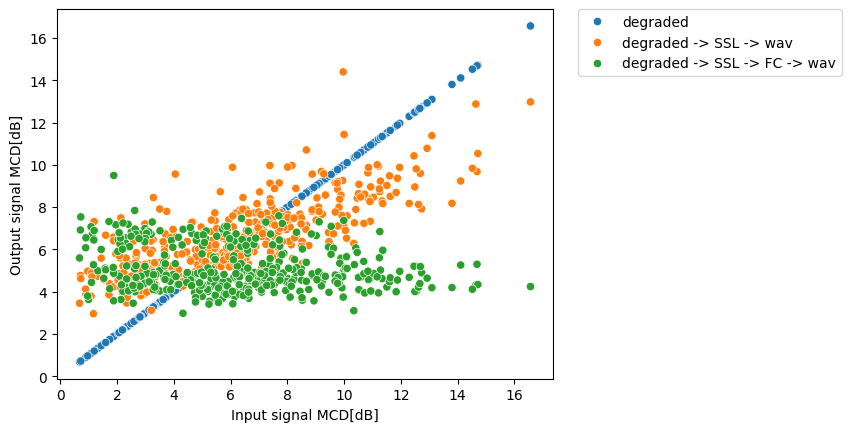

In [19]:
sns.scatterplot(jp_df[(jp_df['label'].str.contains('degraded'))],x='degraded_mcd', y='mcd',hue='label')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Input signal MCD[dB]")
plt.ylabel("Output signal MCD[dB]")
plt.show()
sns.scatterplot(en_df[(en_df['label'].str.contains('degraded'))],x='degraded_mcd', y='mcd',hue='label')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Input signal MCD[dB]")
plt.ylabel("Output signal MCD[dB]")

/tmp/ipykernel_3867645/1502430428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['label'] = plot_df.label.replace(
/tmp/ipykernel_3867645/1502430428.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.boxplot(plot_df[df.lang == 'jp'], y='degration', x='mcd',orient='h',hue='label')


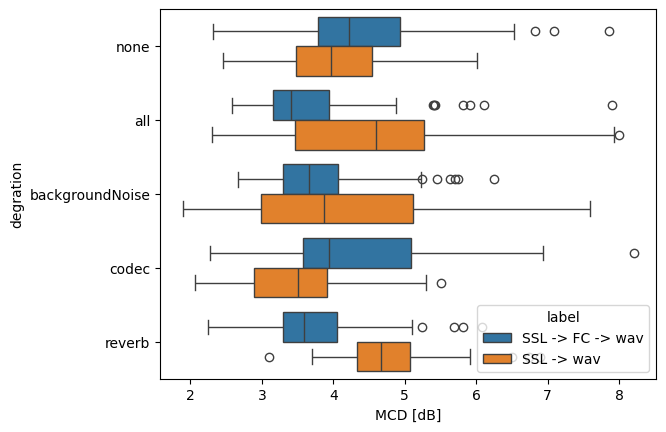

/tmp/ipykernel_3867645/1502430428.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.boxplot(plot_df[df.lang == 'en'], y='degration', x='mcd',orient='h',hue='label')


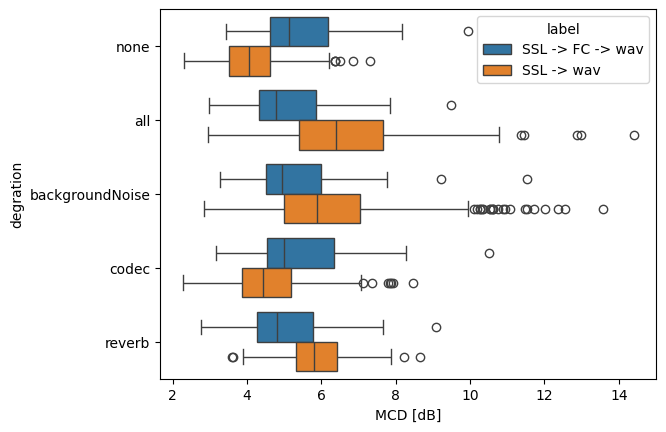

In [36]:
plot_df = df[df.label.str.contains('FC|SSL -> wav')]
plot_df['label'] = plot_df.label.replace(
    {
        'wav -> SSL -> wav':'SSL -> wav',
        'wav -> SSL -> FC -> wav':'SSL -> FC -> wav', 
        'degraded -> SSL -> wav':'SSL -> wav',
        'degraded -> SSL -> FC -> wav':'SSL -> FC -> wav'
})
sns.boxplot(plot_df[df.lang == 'jp'], y='degration', x='mcd',orient='h',hue='label')
plt.xlabel("MCD [dB]")
plt.show()
sns.boxplot(plot_df[df.lang == 'en'], y='degration', x='mcd',orient='h',hue='label')
plt.xlabel("MCD [dB]")
plt.show()

/tmp/ipykernel_3867645/464448285.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.boxplot(plot_df[df.lang == 'jp'], y='degration', x='lf0_mse',orient='h',hue='label')


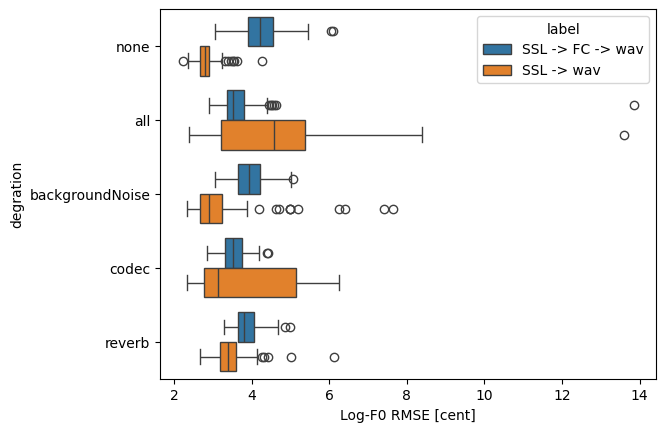

/tmp/ipykernel_3867645/464448285.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.boxplot(plot_df[df.lang == 'en'], y='degration', x='lf0_mse',orient='h',hue='label')


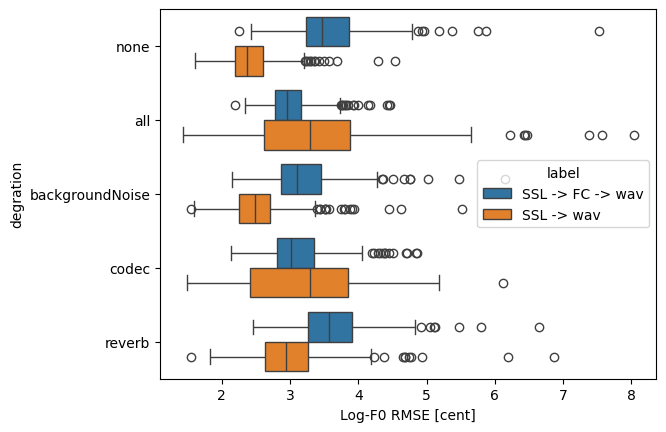

In [39]:
sns.boxplot(plot_df[df.lang == 'jp'], y='degration', x='lf0_mse',orient='h',hue='label')
plt.xlabel("Log-F0 RMSE [cent]")
plt.show()
sns.boxplot(plot_df[df.lang == 'en'], y='degration', x='lf0_mse',orient='h',hue='label')
plt.xlabel("Log-F0 RMSE [cent]")
plt.show()

In [38]:
sns.boxplot(plot_df[df.lang == 'jp'], y='degration', x='xvector_similarity',orient='h',hue='label')
plt.xlabel("Log-F0 RMSE [cent]")
plt.show()
sns.boxplot(plot_df[df.lang == 'en'], y='degration', x='lf0_mse',orient='h',hue='label')
plt.xlabel("Log-F0 RMSE [cent]")
plt.show()

wav_paths    model lang speaker  \
0                     jsut_resampled/BASIC5000_0028.wav      wav   jp    jsut   
1                     jsut_resampled/BASIC5000_0098.wav      wav   jp    jsut   
2                     jsut_resampled/BASIC5000_0050.wav      wav   jp    jsut   
3                     jsut_resampled/BASIC5000_0001.wav      wav   jp    jsut   
4                     jsut_resampled/BASIC5000_0062.wav      wav   jp    jsut   
...                                                 ...      ...  ...     ...   
7495  arctic_resynth_degraded_reverb/cmu_us_rms_arct...  resynth   en   rms_M   
7496  arctic_resynth_degraded_reverb/cmu_us_bdl_arct...  resynth   en   bdl_M   
7497  arctic_resynth_degraded_reverb/cmu_us_rms_arct...  resynth   en   rms_M   
7498  arctic_resynth_degraded_reverb/cmu_us_slt_arct...  resynth   en   slt_F   
7499  arctic_resynth_degraded_reverb/cmu_us_clb_arct...  resynth   en   clb_F   

     degration   lf0_mse  xvector_similarity       mcd  \
0         none  0.000000            0.000000  0.000000   
1         none  0.000000            0.000000  0.000000   
2         none  0.000000            0.000000  0.000000   
3         none  0.000000            0.000000  0.000000   
4         none  0.000000            0.000000  0.000000   
...        ...       ...                 ...       ...   
7495    reverb  2.663154            0.950499  5.217513   
7496    reverb  2.790938            0.953528  5.747144   
7497    reverb  2.541279            0.931234  5.862371   
7498    reverb  2.986538            0.965806  6.425735   
7499    reverb  2.963986            0.974814  5.238471   

                                             transcript  \
0                                  外交官には、様々な特権が与えられている。   
1                        全てを捨てて、このレストランをやる目的は、ひとつだけでした。   
2                               気に入ろうが入るまいが、君は行かねばならない。   
3                               水をマレーシアから買わなくてはならないのです。   
4                       ミラー先生は、あなたにしばらく待ってもらいたいと思っています。   
...                                                 ...   
7495  You were making them talk shop, Ruth charged him.   
7496  You were making them talk shop, Ruth charged him.   
7497  You were making them talk shop, Ruth charged him.   
7498  You were making them talk shop, Ruth charged him.   
7499  You were making them talk shop, Ruth charged him.   

                                                    asr       cer  \
0                                    外交官には様々な徳権が与えられている  0.150000   
1                           全てを捨ててこのレストランをやる目的は一つだけでした。  0.133333   
2                                    キニ色がいる前が君はいかねばならない  0.478261   
3                                水をまれしやから変わなくてはならないのです。  0.260870   
4                        ミラー先生はあなたにしばらく待ってもらいたいと思っています。  0.032258   
...                                                 ...       ...   
7495                   We'll have to watch our chances.  0.693878   
7496   close beside him gleamed the white things of ...  0.877551   
7497                              It was a large canoe.  0.775510   
7498                  Anyway, no one saw her like that.  0.714286   
7499            Yes, it was a man who asked a stranger.  0.734694   

                       label  sort_index  
0                        wav           0  
1                        wav           0  
2                        wav           0  
3                        wav           0  
4                        wav           0  
...                      ...         ...  
7495  degraded -> SSL -> wav           4  
7496  degraded -> SSL -> wav           4  
7497  degraded -> SSL -> wav           4  
7498  degraded -> SSL -> wav           4  
7499  degraded -> SSL -> wav           4  

[7500 rows x 13 columns]

In [25]:
df[df.label.str.contains("FC")].degration.value_counts()

degration
none               500
all                500
backgroundNoise    500
codec              500
reverb             500
Name: count, dtype: int64

<Axes: xlabel='mcd', ylabel='degration'>

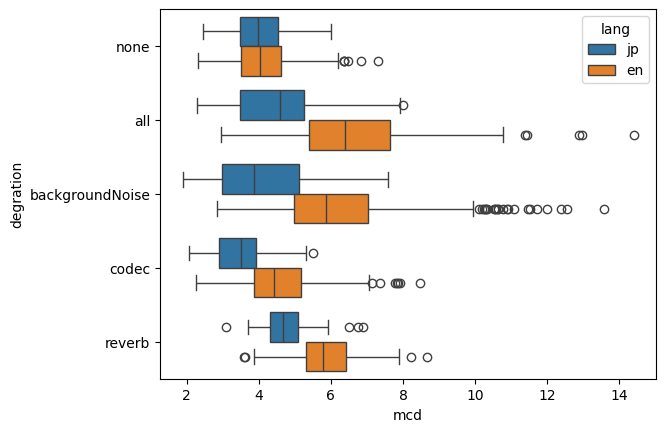

In [27]:
sns.boxplot(df[df['label'].str.contains('SSL -> wav')], y='degration', x='mcd',orient='h',hue='lang')

In [14]:
jp_df.degraded_mcd.value_counts()

degraded_mcd
6.068254    3
1.888100    3
1.761168    3
2.934458    3
4.209277    3
           ..
6.069957    3
1.426472    3
4.461918    3
1.573739    3
5.951110    3
Name: count, Length: 100, dtype: int64

In [10]:
plot_df

wav_paths    model lang speaker  \
0                     jsut_resampled/BASIC5000_0028.wav      wav   jp    jsut   
697   arctic_resampled/cmu_us_slt_arctic_arctic_a001...      wav   en   slt_F   
698   arctic_resampled/cmu_us_slt_arctic_arctic_a009...      wav   en   slt_F   
699   arctic_resampled/cmu_us_slt_arctic_arctic_a009...      wav   en   slt_F   
700   arctic_resampled/cmu_us_rms_arctic_arctic_a000...      wav   en   rms_M   
...                                                 ...      ...  ...     ...   
3640  arctic_miipher_degraded_all/cmu_us_rms_arctic_...  miipher   en   rms_M   
3641  arctic_miipher_degraded_all/cmu_us_rms_arctic_...  miipher   en   rms_M   
3642  arctic_miipher_degraded_all/cmu_us_slt_arctic_...  miipher   en   slt_F   
3629  arctic_miipher_degraded_all/cmu_us_bdl_arctic_...  miipher   en   bdl_M   
3597  arctic_miipher_degraded_all/cmu_us_slt_arctic_...  miipher   en   slt_F   

     degration   lf0_mse  xvector_similarity       mcd  \
0         none  0.000000            0.000000  0.000000   
697       none  0.000000            0.000000  0.000000   
698       none  0.000000            0.000000  0.000000   
699       none  0.000000            0.000000  0.000000   
700       none  0.000000            0.000000  0.000000   
...        ...       ...                 ...       ...   
3640       all  2.588199            0.955513  6.888367   
3641       all  3.320450            0.966900  6.008823   
3642       all  2.662931            0.985698  4.016505   
3629       all  3.131842            0.982415  4.850233   
3597       all  3.235222            0.988814  4.213077   

                                             transcript  \
0                                  外交官には、様々な特権が与えられている。   
697   You were making them talk shop, Ruth charged him.   
698   You were making them talk shop, Ruth charged him.   
699   You were making them talk shop, Ruth charged him.   
700   You were making them talk shop, Ruth charged him.   
...                                                 ...   
3640  You were making them talk shop, Ruth charged him.   
3641  You were making them talk shop, Ruth charged him.   
3642  You were making them talk shop, Ruth charged him.   
3629  You were making them talk shop, Ruth charged him.   
3597  You were making them talk shop, Ruth charged him.   

                                                    asr       cer  \
0                                    外交官には様々な徳権が与えられている  0.150000   
697    There is Fort Churchill, a rifle shop beyond ...  0.959184   
698               The singing voice approached rapidly.  0.775510   
699    A big canvas tent was the first thing to come...  1.000000   
700    and you always want to see it in the superlat...  0.836735   
...                                                 ...       ...   
3640   And now, down there, I leanless waiting for him.  0.734694   
3641                      It was a curious coincidence.  0.775510   
3642   And now, down there, Eileen was waiting for him.  0.734694   
3629   To my surprise, he began to show actual enthu...  0.979592   
3597   There is Fort Churchill, a rifle shop beyond ...  0.959184   

                             label  sort_index  degraded_mcd  
0                              wav           0           NaN  
697                            wav           0           NaN  
698                            wav           0           NaN  
699                            wav           0           NaN  
700                            wav           0           NaN  
...                            ...         ...           ...  
3640  degraded -> SSL -> FC -> wav           5      1.187899  
3641  degraded -> SSL -> FC -> wav           5      2.185150  
3642  degraded -> SSL -> FC -> wav           5      6.067581  
3629  degraded -> SSL -> FC -> wav           5      6.185140  
3597  degraded -> SSL -> FC -> wav           5      3.323778  

[3000 rows x 14 columns]

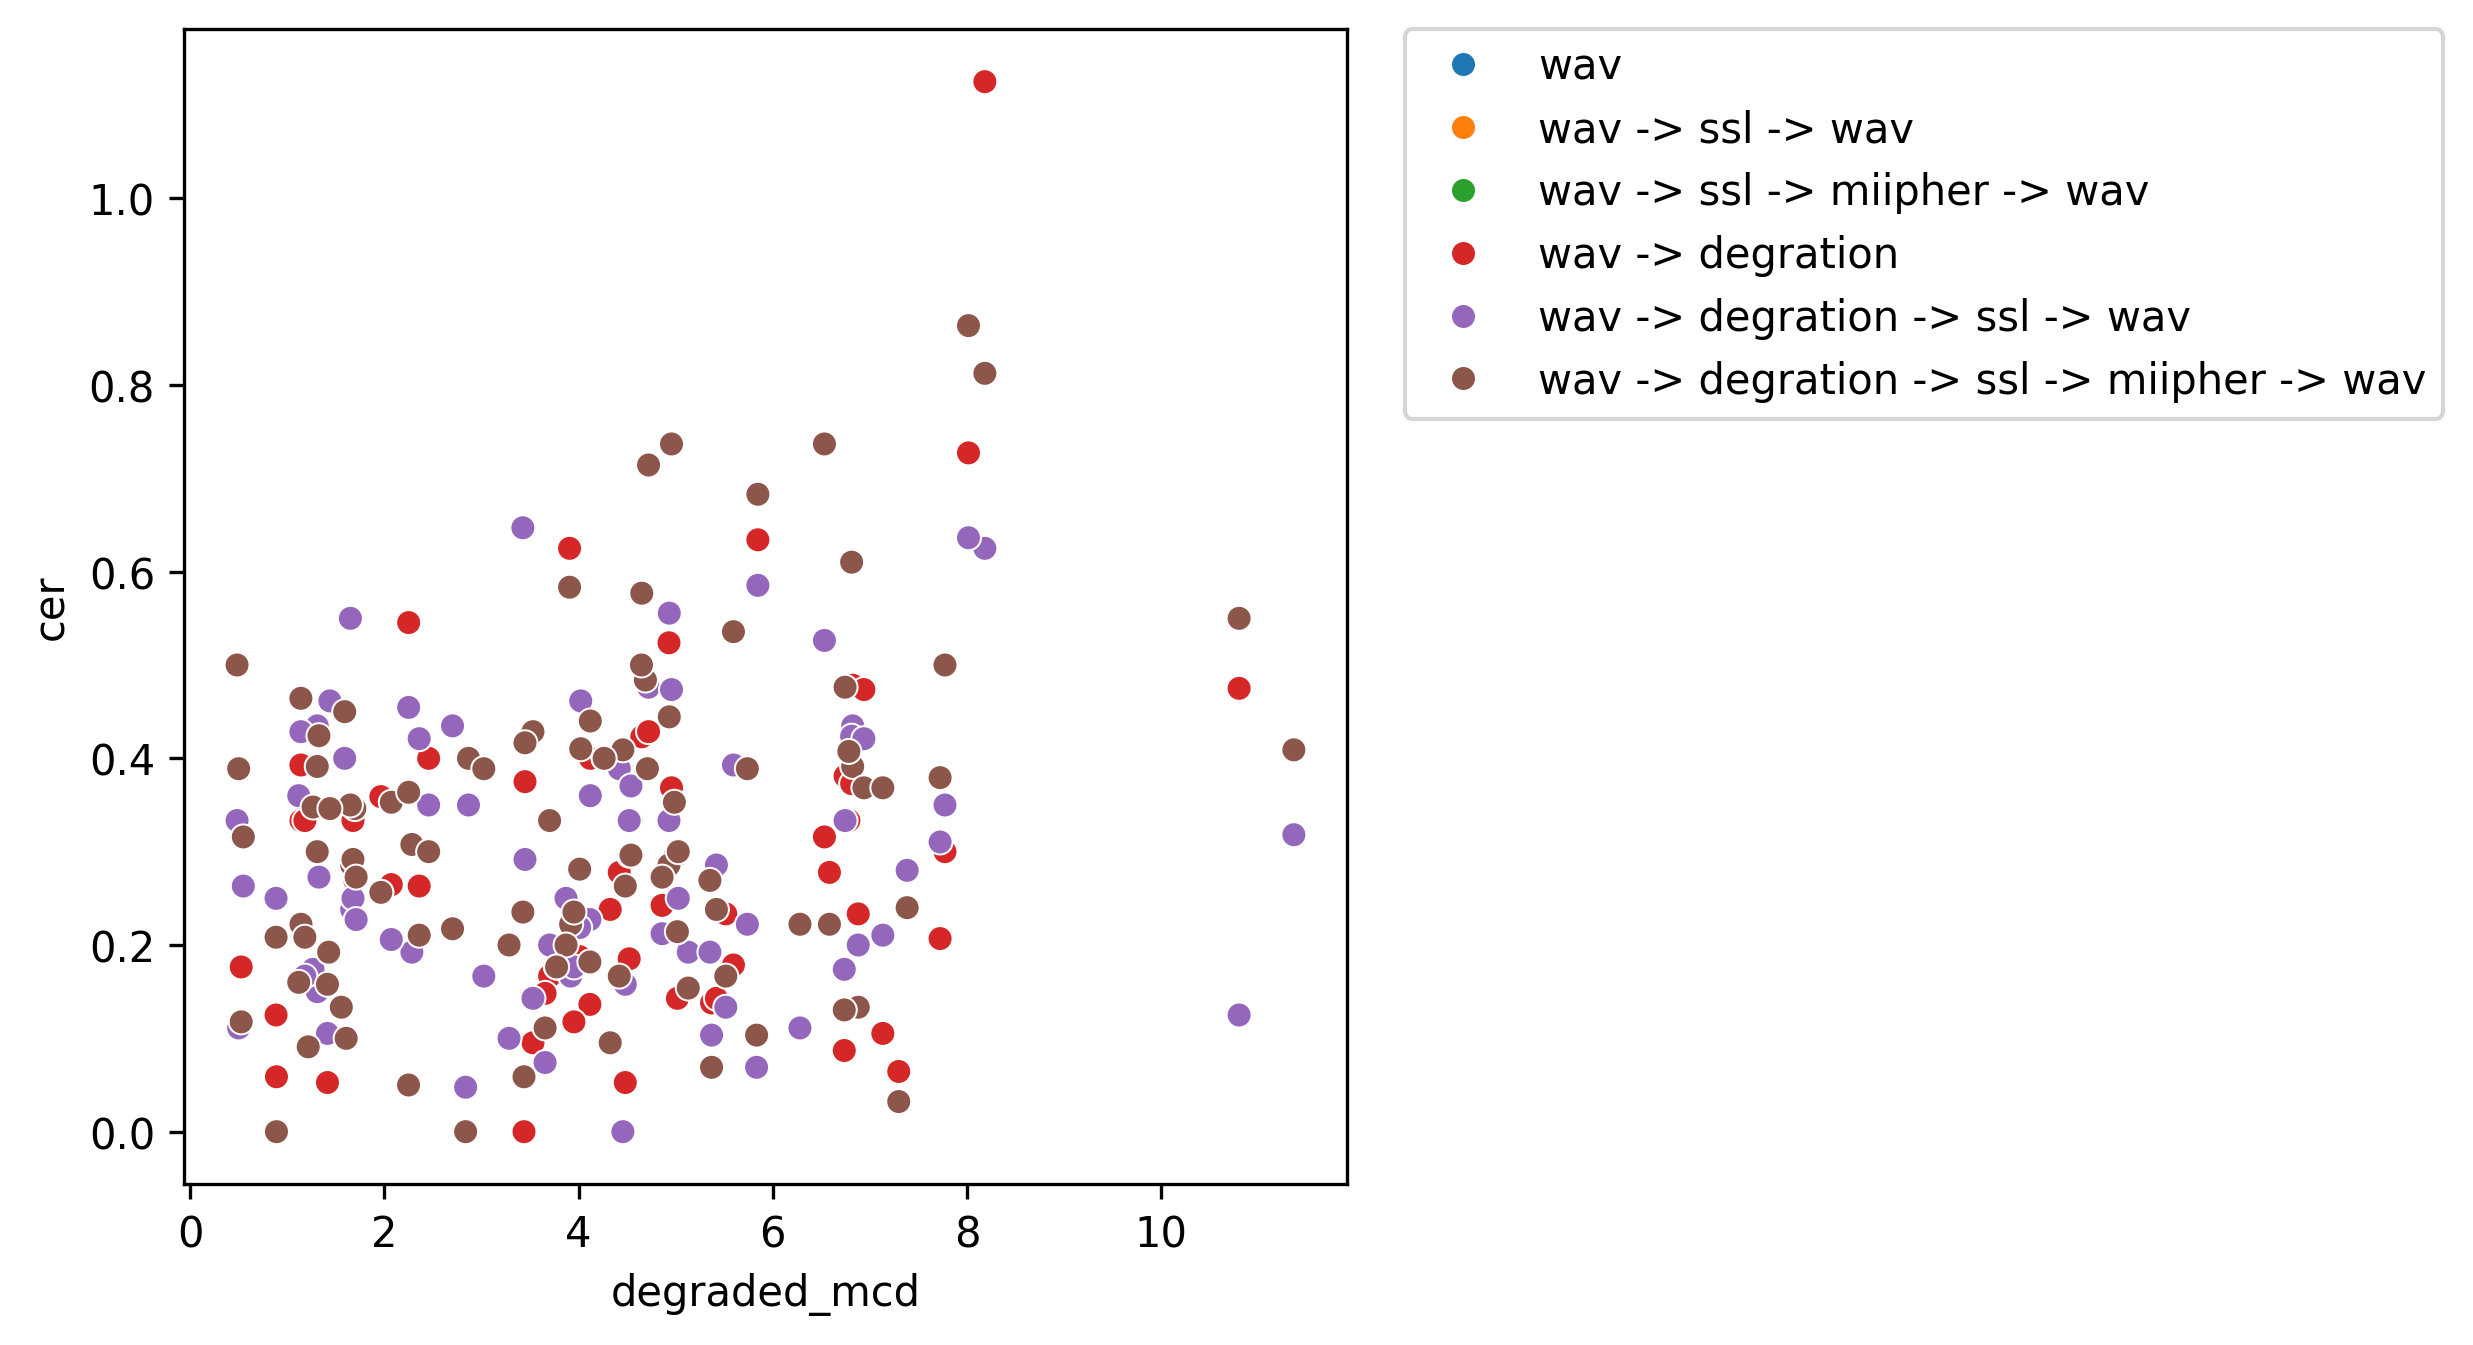

In [68]:
plt.figure(figsize=(5,5),dpi=300)
sns.scatterplot(df[df['degraded_mcd'] !=None],x='degraded_mcd', y='cer',hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

<Axes: xlabel='cer', ylabel='label'>

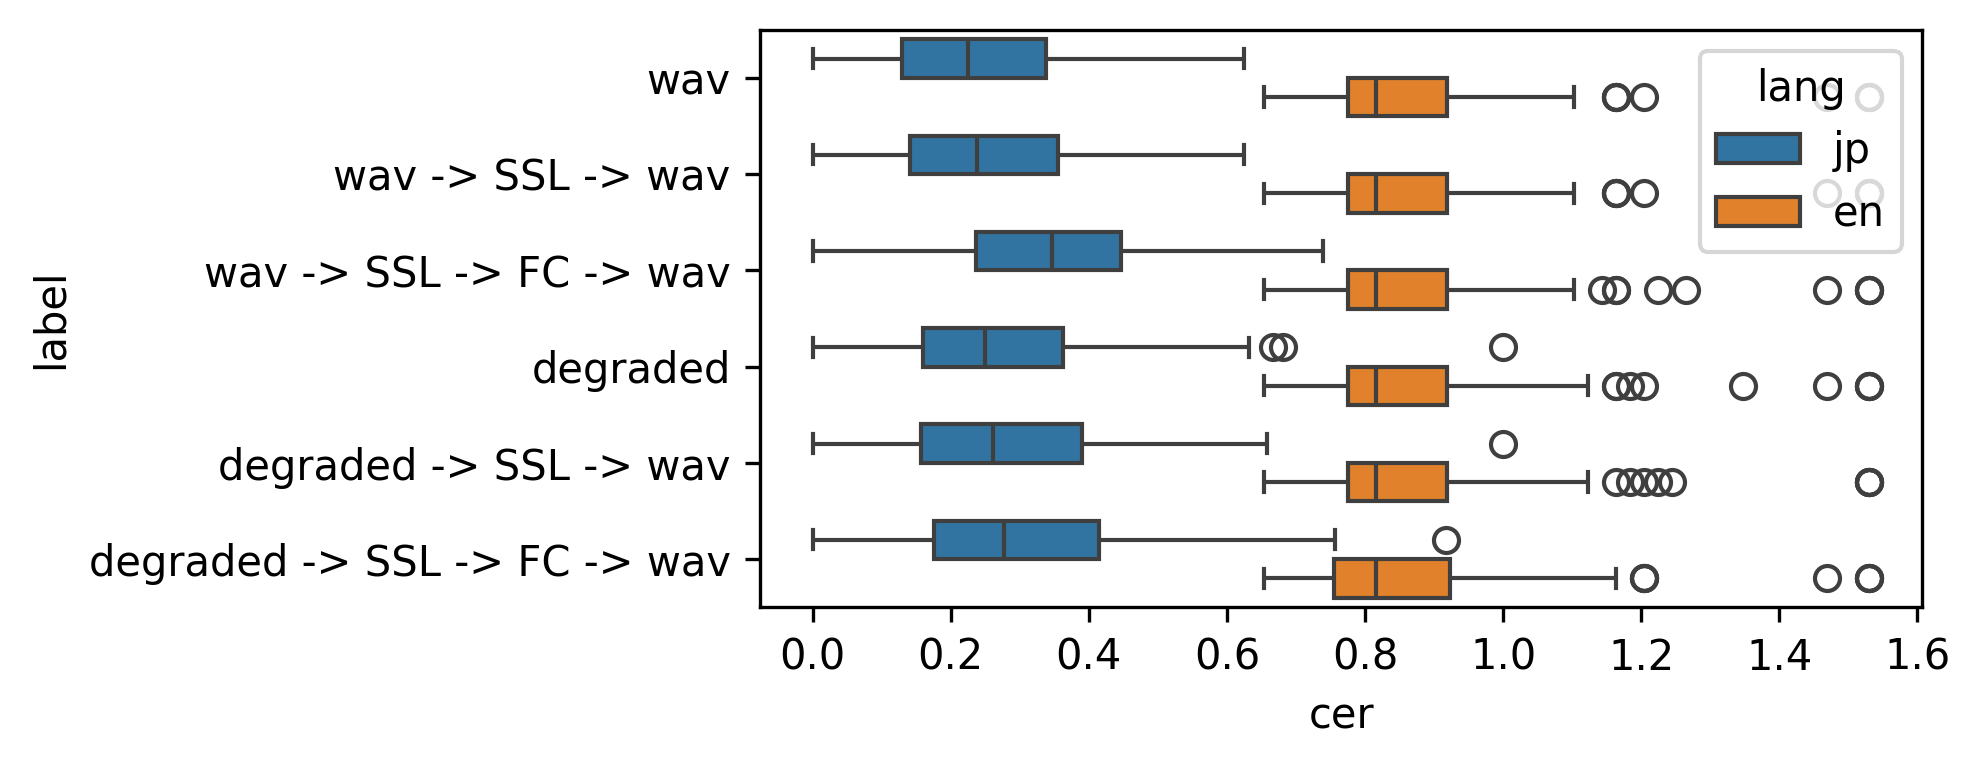

In [21]:
plt.figure(figsize=(5,2.5),dpi=300)
sns.boxplot(plot_df,x='cer', y='label',hue='lang')

In [38]:
df[df['model']== 'wav -> degration -> ssl -> miipher -> wav']['cer'].argmax()

75

In [40]:
df[df['model']== 'wav -> degration -> ssl -> miipher -> wav'].iloc[75]

wav_paths               miipher_degraded_out/BASIC5000_0015.wav
model                 wav -> degration -> ssl -> miipher -> wav
lf0_mse                                                3.833584
xvector_similarity                                     0.983389
mcd                                                    3.460177
transcript                               庭園の周りに、ぐるりと高いへいが立っている。
asr                                       天井生ーり誰ばよりしていてご視聴終わりです
cer                                                    0.863636
degraded_mcd                                           8.014746
Name: 575, dtype: object

In [42]:
degraded_miipher_df =df[df['model']== 'wav -> degration -> ssl -> miipher -> wav']
print((degraded_miipher_df['mcd'] - degraded_miipher_df['degraded_mcd']).argmax())
print((degraded_miipher_df['mcd'] - degraded_miipher_df['degraded_mcd']).argmin())

94
43


In [49]:
from IPython.display import Audio, display
display(Audio("degraded/" + degraded_miipher_df.iloc[94]['wav_paths'].name))
display(Audio(degraded_miipher_df.iloc[94]['wav_paths']))

In [51]:
display(Audio("degraded/" + degraded_miipher_df.iloc[43]['wav_paths'].name))
display(Audio(degraded_miipher_df.iloc[43]['wav_paths']))

In [70]:
degraded_miipher_df.iloc[43]['wav_paths'].name

'BASIC5000_0068.wav'

In [66]:
print((degraded_miipher_df['cer']).argmax())
print((degraded_miipher_df['cer']).argmin())

75
23


In [67]:
display(Audio("degraded/" + degraded_miipher_df.iloc[75]['wav_paths'].name))
display(Audio(degraded_miipher_df.iloc[75]['wav_paths']))